# **Data Cleaning**

## Objectives

* Clean data
* Split into train and test set
  
## Inputs

* The maternal health dataset from outputs/datasets/collection/maternal-healt-dataset.csv

## Outputs

* Generate cleaned train and test sets and save to outputs/datasets/cleaned

---

# Import Packages for Data Collection

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Load Data

In [5]:
df = pd.read_csv('outputs/datasets/collection/maternal-health-risk-dataset.csv')
df.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Data Exploration

To help us decide which steps to take in the data cleaning process, let us review the data and its statistical summary of the data again.

In [6]:
df.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


In [7]:
df.tail()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,36.7,80,2
1010,55,120,90,18.0,36.7,60,2
1011,35,85,60,19.0,36.7,86,2
1012,43,120,90,18.0,36.7,70,2
1013,32,120,65,6.0,38.3,76,1


In [8]:
df.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,37.059763,74.301775,0.867850
std,13.474386,18.403913,13.885796,3.293532,0.743991,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,36.700000,7.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,36.700000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,36.700000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,36.700000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,39.400000,90.000000,2.000000


In [9]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BloodSugar     0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

### Summary:

* There is no missing data
* The outliers were discussed in the 02-MaternalHealthRiskStudyA.ipynb notebook and we came to the conclusion to remove one extreme value in the age and two in the heartrate columns.
* After taking care of the outliers we will conduct a more detailed correlation and PPA study.

---

# Outliers

In this section we will remove the two outliers we found in the age and in the heartrate columns, that seem to be erronous entries into the database.

Let us recall, by visualising the two features in box plots once again.

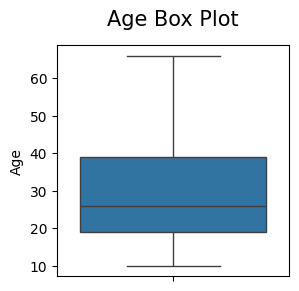

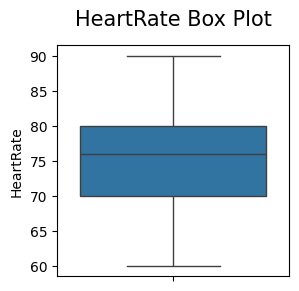

In [22]:
for var in df.filter(["Age", "HeartRate"]):
    plt.figure(figsize=(3,3))
    sns.boxplot(data=df[var])
    plt.title(f"{var} Box Plot", fontsize=15, y=1.05)
    plt.show()

Compute the range limits where outliers start for the age and heartrate columns.

In [11]:
IQR_age = df["Age"].quantile(q=0.75) - df["Age"].quantile(q=0.25)
outlier_age = df["Age"].quantile(q=0.75) + 1.5 * IQR_age

IQR_hr = df["HeartRate"].quantile(q=0.75) - df["HeartRate"].quantile(q=0.25)
outlier_hr = df["HeartRate"].quantile(q=0.25) - 1.5 * IQR_hr

print(f"The upper limit for age is: {outlier_age}, the lower limit for heartrate is: {outlier_hr}") 

The upper limit for age is: 69.0, the lower limit for heartrate is: 55.0


In [12]:
df.query(f"Age >= {outlier_age} | HeartRate < {outlier_hr}")

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.9,38.9,70,0
499,16,120,75,7.9,36.7,7,0
908,16,120,75,7.9,36.7,7,0


In [13]:
indices_to_drop = df.query(f"Age >= {outlier_age} | HeartRate < {outlier_hr}").index.to_list()
df.shape

(1014, 7)

In [14]:
df.drop(indices_to_drop).shape

(1011, 7)

**Imortant!** Now drop the three rows in the dataframe:

In [15]:
df.drop(indices_to_drop, inplace=True)

In [17]:
df.shape

(1011, 7)

---

# Correlation and PPS Analysis

In this section we conduct a more detailed correlation study and in particular investigate the dataset for collinearity. This means, we look for features that are correlated between themselves and would thus decrease model performance. We also investigate the predictive power score to see which variables have the most predictive power over the target or between themselves.

Note that in the correlation study in the MaternalHealthRiskStudy notebooks we did not consider Pearson correlation, since it is only useful for continuous variables and our target is categorical.

Here however, we consider both Spearman and Pearson correlation, since we also investigate the correlation between the features and those are continuous.

In [18]:
# The code for this function was taken from the Code Institute Churnometer Walkthrough project and was adapted for the case at hand

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(index='y', columns='x', values='ppscore')
    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


In [19]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore   42.0  0.096  0.121  0.0  0.0  0.062  0.132  0.522


In [20]:
pps_matrix

x,Age,BloodSugar,BodyTemp,DiastolicBP,HeartRate,RiskLevel,SystolicBP
y,,,,,,,
Age,1.000000,0.196733,0.015574,0.116254,0.071195,0.052009,0.110549
BloodSugar,0.131588,1.000000,0.000000,0.000000,0.000000,0.131262,0.041356
BodyTemp,0.139708,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
DiastolicBP,0.308552,0.126219,0.028361,1.000000,0.121509,0.031491,0.521774
HeartRate,0.250791,0.081647,0.004647,0.072196,1.000000,0.000000,0.081400
RiskLevel,0.143374,0.258264,0.000000,0.105215,0.000000,1.000000,0.230973
SystolicBP,0.161053,0.002135,0.000000,0.448236,0.041020,0.000000,1.000000




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



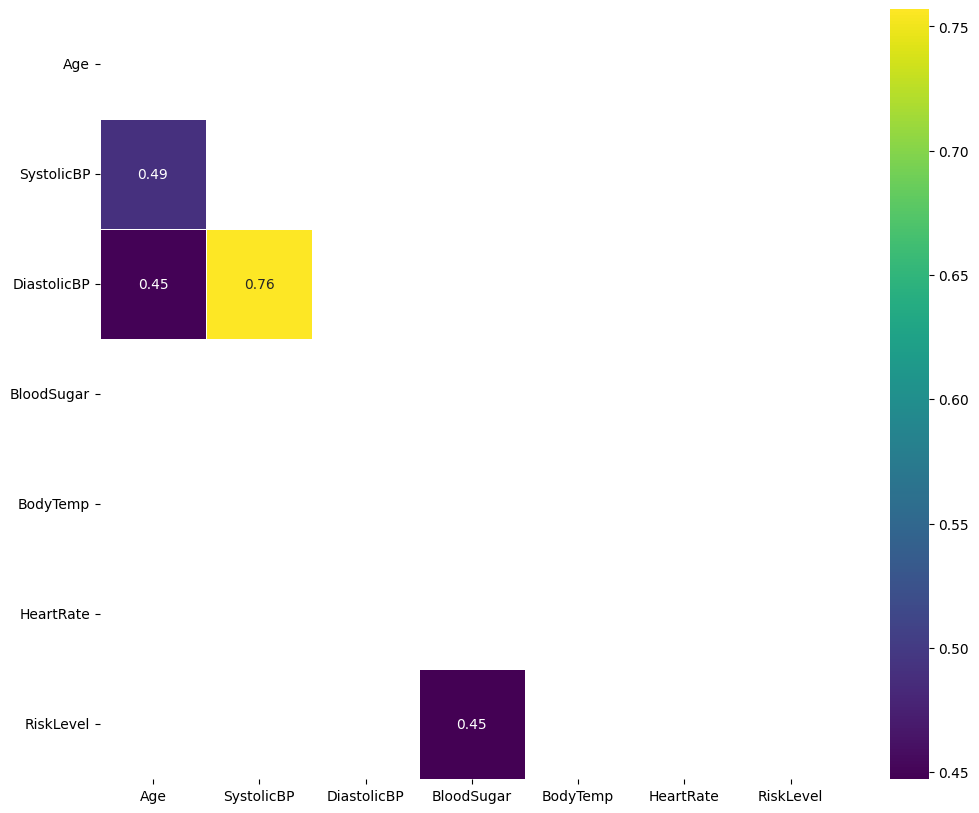



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



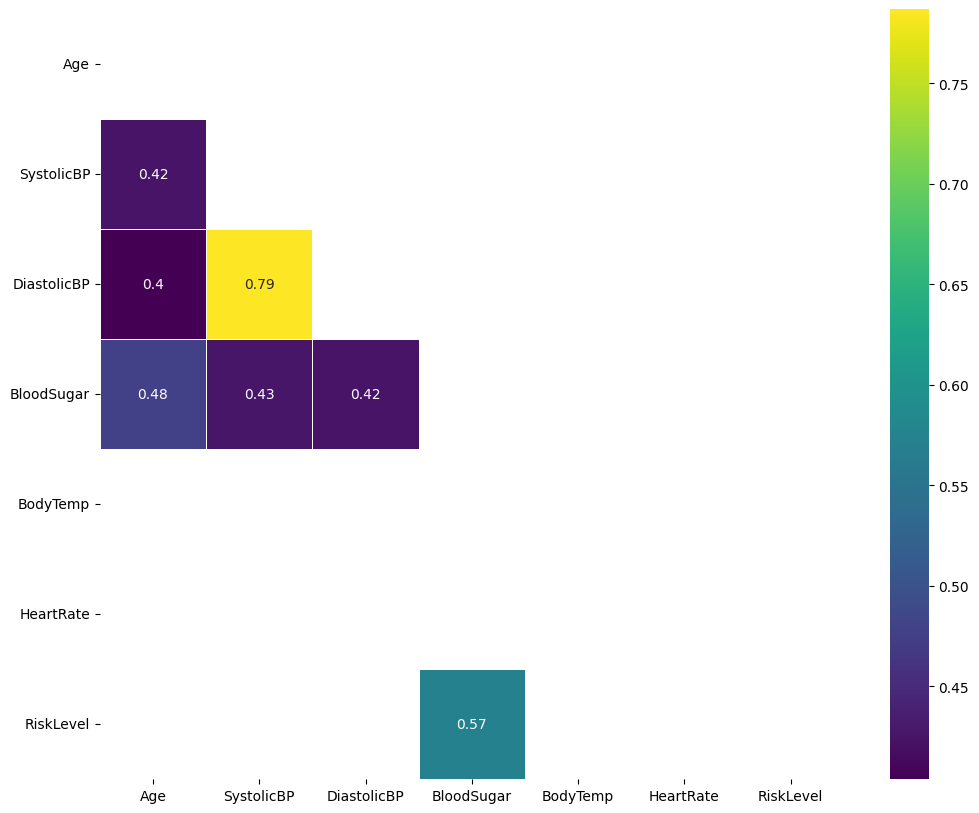



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



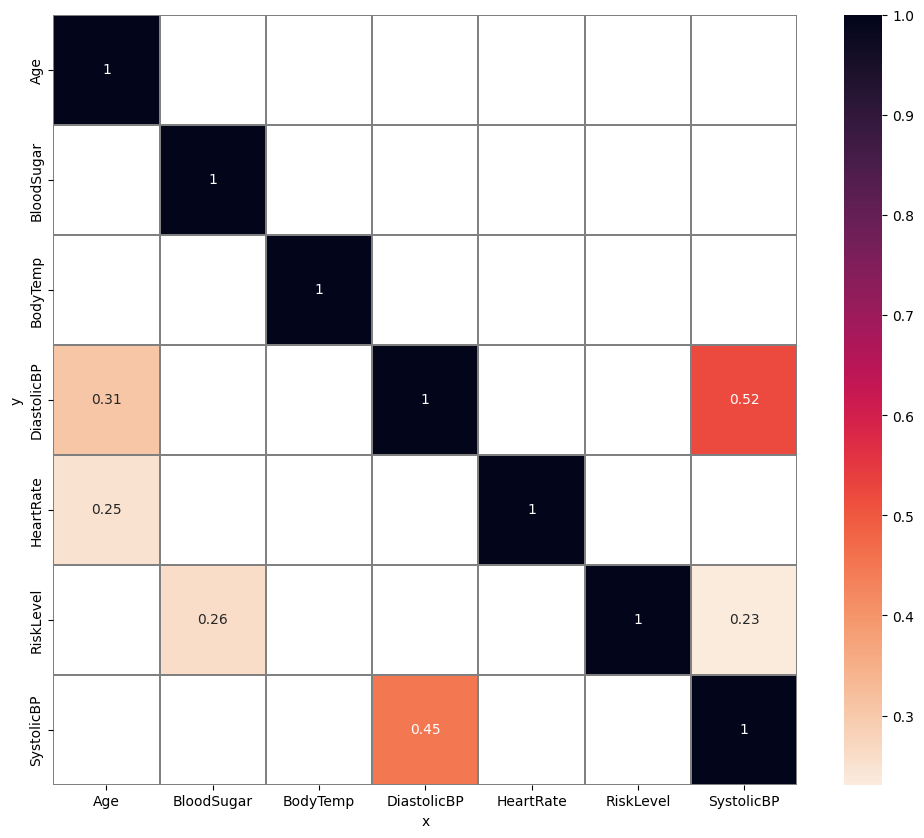

In [21]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)


---

## Split into Train and Test Sets

In [23]:

from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['RiskLevel'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (808, 7) 
TestSet shape: (203, 7)


---

## Push Files to Repo

---

# Conclusions and Next Steps



* We removed a few outliers that seemed to be erronous entries into the database
* We conducted a correlation and PPS analysis and decided to remove the following features:
* We then split the cleaned dataset into train and test sets and stored them to outputs/datasets/cleaned